In [1]:
# CART
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from random import seed, randrange
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right
 
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini
 
# Select the best split point for a dataset
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}
 
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)
 
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        print('left')
        print('Split: [X%d <= %.3f]' % ((node['index']+1), node['value']))
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        print('right')
        print('Split: [X%d >= %.3f]' % ((node['index']+1), node['value']))
        split(node['right'], max_depth, min_size, depth+1)

# Build a decision tree
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    print('root')
    print('Split: [X%d <= %.3f]' % ((root['index']+1), root['value']))
    split(root, max_depth, min_size, 1)
    return root
 
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']


# Classification and Regression Tree Algorithm
def decision_tree(train, test, max_depth, min_size):
    tree = build_tree(train, max_depth, min_size)
    predictions = list()
    for row in test:
        prediction = predict(tree, row)
        predictions.append(prediction)
    return(predictions)


def evaluate_algorithm(train, test, algorithm, *args):
    y_pred = algorithm(train, test, *args)
    y_real = [col[-1] for col in test]
    accuracy = accuracy_score(y_pred, y_real) * 100.
    conf_matrix = confusion_matrix(y_pred, y_real)
    count_right = sum([conf_matrix[i, j]
                   for i in range(len(conf_matrix))
                   for j in range(len(conf_matrix[0]))
                   if i == j])
    count_false = sum(sum(conf_matrix)) - count_right

    return accuracy, conf_matrix, count_right, count_false


def plot_conf_matrix(conf_matrix, figsize=(3,2)):
    df_cm = pd.DataFrame(conf_matrix, index=range(3), columns=range(3))
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.2) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()


def exp_func(train, test, max_depth_list=[1, 2, 3, 4], min_size_list=[1, 3, 5]):
    df = pd.DataFrame(columns=['n_exp', 'max_depth', 'min_size', 'accuracy', 'count_right', 'count_false'])
    # evaluate algorithm
    n_exp = 1
    for max_depth in max_depth_list:
        print(f"max_depth = {max_depth}")
        for min_size in min_size_list:
            print(f"min_size = {min_size}")
            accuracy, conf_matrix, count_right, count_false = \
                evaluate_algorithm(train, test, decision_tree, max_depth, min_size)
            df = df.append({
                            'n_exp': n_exp,
                            'max_depth': max_depth,
                            'min_size': min_size,
                            'accuracy': accuracy,
                            'count_right': count_right,
                            'count_false': count_false
                            },
                           ignore_index=True)
            plot_conf_matrix(conf_matrix)
            n_exp += 1
    df['n_exp'] = df['n_exp'].astype('int')
    df['max_depth'] = df['max_depth'].astype('int')
    df['min_size'] = df['min_size'].astype('int')
    df['count_right'] = df['count_right'].astype('int')
    df['count_false'] = df['count_false'].astype('int')

    return df

C:\ProgramData\Anaconda3\envs\ba-env\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Experiment_1

In [2]:
seed(1)
data = datasets.load_wine()
X = data['data']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
train = [list(row) + [target_tmp] for row, target_tmp in zip(X_train, y_train)]
test = [list(row) + [target_tmp] for row, target_tmp in zip(X_test, y_test)]
print(f"Train size = {len(train)} x {len(train[0])}")
print(f"Test size = {len(test)} x {len(test[0])}")

Train size = 124 x 14
Test size = 54 x 14


max_depth = 1
min_size = 1
root
Split: [X10 <= 3.840]


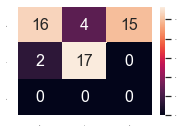

min_size = 3
root
Split: [X10 <= 3.840]


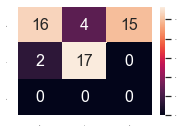

min_size = 5
root
Split: [X10 <= 3.840]


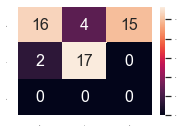

max_depth = 2
min_size = 1
root
Split: [X10 <= 3.840]
left
Split: [X10 <= 3.840]
right
Split: [X10 >= 3.840]


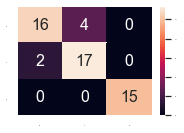

min_size = 3
root
Split: [X10 <= 3.840]
left
Split: [X10 <= 3.840]
right
Split: [X10 >= 3.840]


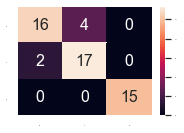

min_size = 5
root
Split: [X10 <= 3.840]
left
Split: [X10 <= 3.840]
right
Split: [X10 >= 3.840]


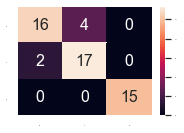

max_depth = 3
min_size = 1
root
Split: [X10 <= 3.840]
left
Split: [X10 <= 3.840]
left
Split: [X3 <= 3.220]
right
Split: [X10 >= 3.840]
left
Split: [X7 <= 1.590]
right
Split: [X7 >= 1.590]


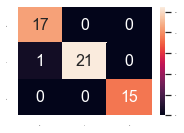

min_size = 3
root
Split: [X10 <= 3.840]
left
Split: [X10 <= 3.840]
left
Split: [X3 <= 3.220]
right
Split: [X10 >= 3.840]
left
Split: [X7 <= 1.590]
right
Split: [X7 >= 1.590]


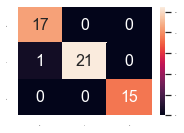

min_size = 5
root
Split: [X10 <= 3.840]
left
Split: [X10 <= 3.840]
left
Split: [X3 <= 3.220]
right
Split: [X10 >= 3.840]
left
Split: [X7 <= 1.590]
right
Split: [X7 >= 1.590]


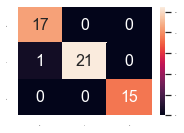

max_depth = 4
min_size = 1
root
Split: [X10 <= 3.840]
left
Split: [X10 <= 3.840]
left
Split: [X3 <= 3.220]
left
Split: [X12 <= 3.820]
right
Split: [X10 >= 3.840]
left
Split: [X7 <= 1.590]
right
Split: [X3 >= 2.100]
right
Split: [X7 >= 1.590]
left
Split: [X13 <= 735.000]
right
Split: [X13 >= 735.000]


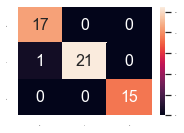

min_size = 3
root
Split: [X10 <= 3.840]
left
Split: [X10 <= 3.840]
left
Split: [X3 <= 3.220]
left
Split: [X12 <= 3.820]
right
Split: [X10 >= 3.840]
left
Split: [X7 <= 1.590]
right
Split: [X3 >= 2.100]
right
Split: [X7 >= 1.590]
left
Split: [X13 <= 735.000]
right
Split: [X13 >= 735.000]


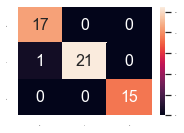

min_size = 5
root
Split: [X10 <= 3.840]
left
Split: [X10 <= 3.840]
left
Split: [X3 <= 3.220]
left
Split: [X12 <= 3.820]
right
Split: [X10 >= 3.840]
left
Split: [X7 <= 1.590]
right
Split: [X3 >= 2.100]
right
Split: [X7 >= 1.590]
left
Split: [X13 <= 735.000]
right
Split: [X13 >= 735.000]


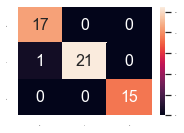

n_exp  max_depth  min_size   accuracy  count_right  count_false
0       1          1         1  61.111111           33           21
1       2          1         3  61.111111           33           21
2       3          1         5  61.111111           33           21
3       4          2         1  88.888889           48            6
4       5          2         3  88.888889           48            6
5       6          2         5  88.888889           48            6
6       7          3         1  98.148148           53            1
7       8          3         3  98.148148           53            1
8       9          3         5  98.148148           53            1
9      10          4         1  98.148148           53            1
10     11          4         3  98.148148           53            1
11     12          4         5  98.148148           53            1

In [3]:
df = exp_func(train, test, max_depth_list=[1, 2, 3, 4], min_size_list=[1, 3, 5])
df

# Experiment_2

Train size = 100 x 14
Test size = 54 x 14
max_depth = 1
min_size = 1
root
Split: [X10 <= 4.000]


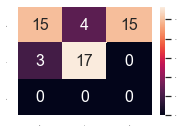

min_size = 3
root
Split: [X10 <= 4.000]


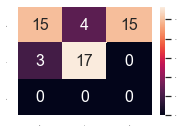

min_size = 5
root
Split: [X10 <= 4.000]


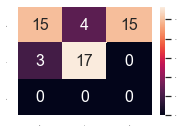

max_depth = 2
min_size = 1
root
Split: [X10 <= 4.000]
left
Split: [X10 <= 4.000]
right
Split: [X10 >= 4.000]


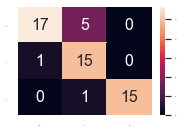

min_size = 3
root
Split: [X10 <= 4.000]
left
Split: [X10 <= 4.000]
right
Split: [X10 >= 4.000]


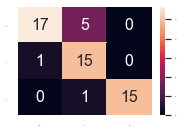

min_size = 5
root
Split: [X10 <= 4.000]
left
Split: [X10 <= 4.000]
right
Split: [X10 >= 4.000]


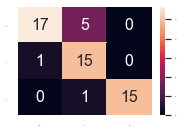

max_depth = 3
min_size = 1
root
Split: [X10 <= 4.000]
left
Split: [X10 <= 4.000]
left
Split: [X1 <= 13.050]
right
Split: [X1 >= 13.050]
right
Split: [X10 >= 4.000]
left
Split: [X12 <= 2.510]
right
Split: [X12 >= 2.510]


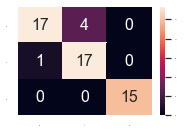

min_size = 3
root
Split: [X10 <= 4.000]
left
Split: [X10 <= 4.000]
left
Split: [X1 <= 13.050]
right
Split: [X1 >= 13.050]
right
Split: [X10 >= 4.000]
left
Split: [X12 <= 2.510]
right
Split: [X12 >= 2.510]


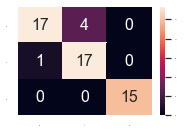

min_size = 5
root
Split: [X10 <= 4.000]
left
Split: [X10 <= 4.000]
left
Split: [X1 <= 13.050]
right
Split: [X1 >= 13.050]
right
Split: [X10 >= 4.000]
left
Split: [X12 <= 2.510]
right
Split: [X12 >= 2.510]


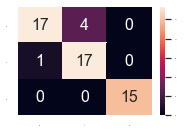

max_depth = 4
min_size = 1
root
Split: [X10 <= 4.000]
left
Split: [X10 <= 4.000]
left
Split: [X1 <= 13.050]
right
Split: [X1 >= 11.450]
right
Split: [X1 >= 13.050]
left
Split: [X5 <= 96.000]
right
Split: [X5 >= 96.000]
right
Split: [X10 >= 4.000]
left
Split: [X12 <= 2.510]
left
Split: [X7 <= 1.590]
right
Split: [X7 >= 1.590]
right
Split: [X12 >= 2.510]
left
Split: [X1 <= 13.750]
right
Split: [X1 >= 13.750]


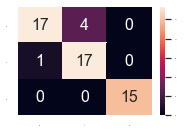

min_size = 3
root
Split: [X10 <= 4.000]
left
Split: [X10 <= 4.000]
left
Split: [X1 <= 13.050]
right
Split: [X1 >= 11.450]
right
Split: [X1 >= 13.050]
right
Split: [X10 >= 4.000]
left
Split: [X12 <= 2.510]
left
Split: [X7 <= 1.590]
right
Split: [X12 >= 2.510]
left
Split: [X1 <= 13.750]
right
Split: [X1 >= 13.750]


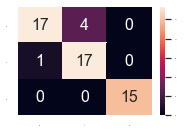

min_size = 5
root
Split: [X10 <= 4.000]
left
Split: [X10 <= 4.000]
left
Split: [X1 <= 13.050]
right
Split: [X1 >= 11.450]
right
Split: [X1 >= 13.050]
right
Split: [X10 >= 4.000]
left
Split: [X12 <= 2.510]
left
Split: [X7 <= 1.590]
right
Split: [X12 >= 2.510]
left
Split: [X1 <= 13.750]
right
Split: [X1 >= 13.750]


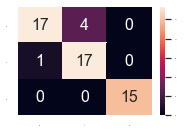

n_exp  max_depth  min_size   accuracy  count_right  count_false
0       1          1         1  59.259259           32           22
1       2          1         3  59.259259           32           22
2       3          1         5  59.259259           32           22
3       4          2         1  87.037037           47            7
4       5          2         3  87.037037           47            7
5       6          2         5  87.037037           47            7
6       7          3         1  90.740741           49            5
7       8          3         3  90.740741           49            5
8       9          3         5  90.740741           49            5
9      10          4         1  90.740741           49            5
10     11          4         3  90.740741           49            5
11     12          4         5  90.740741           49            5

In [4]:
train = [list(row) + [target_tmp] for row, target_tmp in zip(X_train, y_train)]
test = [list(row) + [target_tmp] for row, target_tmp in zip(X_test, y_test)]
train = train[:100]
print(f"Train size = {len(train)} x {len(train[0])}")
print(f"Test size = {len(test)} x {len(test[0])}")
df = exp_func(train, test, max_depth_list=[1, 2, 3, 4], min_size_list=[1, 3, 5])
df

Train size = 80 x 14
Test size = 54 x 14
max_depth = 1
min_size = 1
root
Split: [X10 <= 3.520]


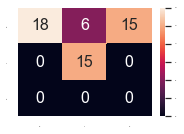

min_size = 3
root
Split: [X10 <= 3.520]


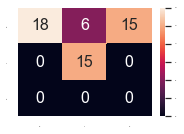

min_size = 5
root
Split: [X10 <= 3.520]


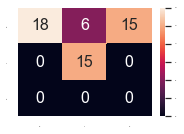

max_depth = 2
min_size = 1
root
Split: [X10 <= 3.520]
left
Split: [X10 <= 3.520]
right
Split: [X10 >= 3.520]


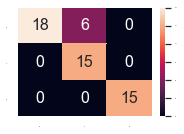

min_size = 3
root
Split: [X10 <= 3.520]
left
Split: [X10 <= 3.520]
right
Split: [X10 >= 3.520]


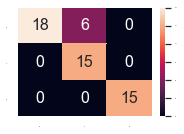

min_size = 5
root
Split: [X10 <= 3.520]
left
Split: [X10 <= 3.520]
right
Split: [X10 >= 3.520]


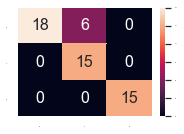

max_depth = 3
min_size = 1
root
Split: [X10 <= 3.520]
left
Split: [X10 <= 3.520]
right
Split: [X10 >= 3.520]
left
Split: [X7 <= 1.570]
right
Split: [X7 >= 1.570]


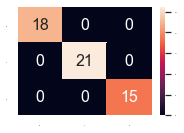

min_size = 3
root
Split: [X10 <= 3.520]
left
Split: [X10 <= 3.520]
right
Split: [X10 >= 3.520]
left
Split: [X7 <= 1.570]
right
Split: [X7 >= 1.570]


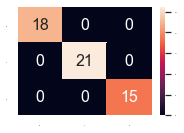

min_size = 5
root
Split: [X10 <= 3.520]
left
Split: [X10 <= 3.520]
right
Split: [X10 >= 3.520]
left
Split: [X7 <= 1.570]
right
Split: [X7 >= 1.570]


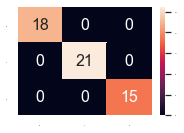

max_depth = 4
min_size = 1
root
Split: [X10 <= 3.520]
left
Split: [X10 <= 3.520]
right
Split: [X10 >= 3.520]
left
Split: [X7 <= 1.570]
left
Split: [X1 <= 12.870]
right
Split: [X1 >= 12.870]
right
Split: [X7 >= 1.570]
left
Split: [X13 <= 735.000]
right
Split: [X13 >= 735.000]


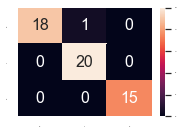

min_size = 3
root
Split: [X10 <= 3.520]
left
Split: [X10 <= 3.520]
right
Split: [X10 >= 3.520]
left
Split: [X7 <= 1.570]
left
Split: [X1 <= 12.870]
right
Split: [X1 >= 12.870]
right
Split: [X7 >= 1.570]
left
Split: [X13 <= 735.000]
right
Split: [X13 >= 735.000]


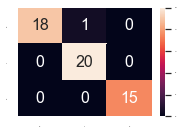

min_size = 5
root
Split: [X10 <= 3.520]
left
Split: [X10 <= 3.520]
right
Split: [X10 >= 3.520]
left
Split: [X7 <= 1.570]
left
Split: [X1 <= 12.870]
right
Split: [X1 >= 12.870]
right
Split: [X7 >= 1.570]
left
Split: [X13 <= 735.000]
right
Split: [X13 >= 735.000]


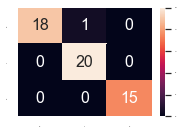

n_exp  max_depth  min_size    accuracy  count_right  count_false
0       1          1         1   61.111111           33           21
1       2          1         3   61.111111           33           21
2       3          1         5   61.111111           33           21
3       4          2         1   88.888889           48            6
4       5          2         3   88.888889           48            6
5       6          2         5   88.888889           48            6
6       7          3         1  100.000000           54            0
7       8          3         3  100.000000           54            0
8       9          3         5  100.000000           54            0
9      10          4         1   98.148148           53            1
10     11          4         3   98.148148           53            1
11     12          4         5   98.148148           53            1

In [5]:
train = [list(row) + [target_tmp] for row, target_tmp in zip(X_train, y_train)]
test = [list(row) + [target_tmp] for row, target_tmp in zip(X_test, y_test)]
train = train[:80]
print(f"Train size = {len(train)} x {len(train[0])}")
print(f"Test size = {len(test)} x {len(test[0])}")
df = exp_func(train, test, max_depth_list=[1, 2, 3, 4], min_size_list=[1, 3, 5])
df

Train size = 60 x 14
Test size = 54 x 14
max_depth = 1
min_size = 1
root
Split: [X10 <= 3.520]


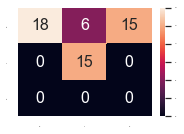

min_size = 3
root
Split: [X10 <= 3.520]


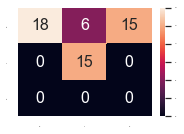

min_size = 5
root
Split: [X10 <= 3.520]


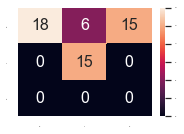

max_depth = 2
min_size = 1
root
Split: [X10 <= 3.520]
left
Split: [X10 <= 3.520]
right
Split: [X10 >= 3.520]


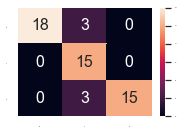

min_size = 3
root
Split: [X10 <= 3.520]
left
Split: [X10 <= 3.520]
right
Split: [X10 >= 3.520]


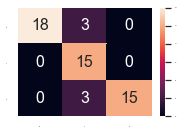

min_size = 5
root
Split: [X10 <= 3.520]
left
Split: [X10 <= 3.520]
right
Split: [X10 >= 3.520]


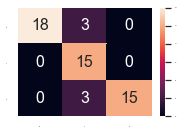

max_depth = 3
min_size = 1
root
Split: [X10 <= 3.520]
left
Split: [X10 <= 3.520]
right
Split: [X10 >= 3.520]
left
Split: [X12 <= 2.650]
right
Split: [X12 >= 2.650]


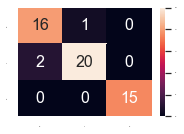

min_size = 3
root
Split: [X10 <= 3.520]
left
Split: [X10 <= 3.520]
right
Split: [X10 >= 3.520]
left
Split: [X12 <= 2.650]
right
Split: [X12 >= 2.650]


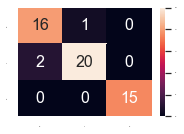

min_size = 5
root
Split: [X10 <= 3.520]
left
Split: [X10 <= 3.520]
right
Split: [X10 >= 3.520]
left
Split: [X12 <= 2.650]
right
Split: [X12 >= 2.650]


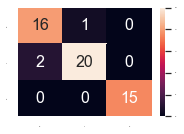

max_depth = 4
min_size = 1
root
Split: [X10 <= 3.520]
left
Split: [X10 <= 3.520]
right
Split: [X10 >= 3.520]
left
Split: [X12 <= 2.650]
left
Split: [X7 <= 1.570]
right
Split: [X7 >= 1.570]
right
Split: [X12 >= 2.650]
right
Split: [X1 >= 13.050]


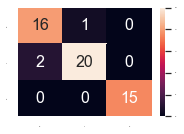

min_size = 3
root
Split: [X10 <= 3.520]
left
Split: [X10 <= 3.520]
right
Split: [X10 >= 3.520]
left
Split: [X12 <= 2.650]
left
Split: [X7 <= 1.570]
right
Split: [X12 >= 2.650]
right
Split: [X1 >= 13.050]


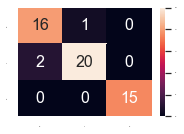

min_size = 5
root
Split: [X10 <= 3.520]
left
Split: [X10 <= 3.520]
right
Split: [X10 >= 3.520]
left
Split: [X12 <= 2.650]
left
Split: [X7 <= 1.570]
right
Split: [X12 >= 2.650]
right
Split: [X1 >= 13.050]


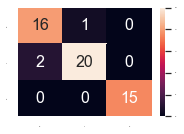

n_exp  max_depth  min_size   accuracy  count_right  count_false
0       1          1         1  61.111111           33           21
1       2          1         3  61.111111           33           21
2       3          1         5  61.111111           33           21
3       4          2         1  88.888889           48            6
4       5          2         3  88.888889           48            6
5       6          2         5  88.888889           48            6
6       7          3         1  94.444444           51            3
7       8          3         3  94.444444           51            3
8       9          3         5  94.444444           51            3
9      10          4         1  94.444444           51            3
10     11          4         3  94.444444           51            3
11     12          4         5  94.444444           51            3

In [6]:
train = [list(row) + [target_tmp] for row, target_tmp in zip(X_train, y_train)]
test = [list(row) + [target_tmp] for row, target_tmp in zip(X_test, y_test)]
train = train[:60]
print(f"Train size = {len(train)} x {len(train[0])}")
print(f"Test size = {len(test)} x {len(test[0])}")
df = exp_func(train, test, max_depth_list=[1, 2, 3, 4], min_size_list=[1, 3, 5])
df